# Character Level Language Model


## Table of Contents

- [Packages](#0)
- [1 - Problem Statement](#1)
    - [1.1 - Dataset and Preprocessing](#1-1)
    - [1.2 - Overview of the Model](#1-2)
- [2 - Building Blocks of the Model](#2)
    - [2.1 - Clipping the Gradients in the Optimization Loop](#2-1)
    - [2.2 - Sampling](#2-2)
- [3 - Building the Language Model](#3)
    - [3.1 - Gradient Descent](#3-1)
    - [3.2 - Training the Model](#3-2)
- [4 - Writing like Shakespeare](#4)
- [5 - References](#5)

<a name='0'></a>
## Packages

In [ ]:
import numpy as np
from utils import *
import random
import pprint
import copy

<a name='1'></a>
## 1 - Problem Statement

<a name='1-1'></a>
### 1.1 - Dataset and Preprocessing

We can run the following cell to read the dataset of dinosaur names, create a list of unique characters (such as a-z), and compute the dataset and vocabulary size.

In [ ]:
data = open('dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 19909 total characters and 27 unique characters in your data.


In [ ]:
chars = sorted(chars)
print(chars)

['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(ix_to_char)

{   0: '\n',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'}


<a name='1-2'></a>
### 1.2 - Overview of the Model

My model had the following structure:

- Initialize parameters
- Run the optimization loop
    - Forward propagation to compute the loss function
    - Backward propagation to compute the gradients with respect to the loss function
    - Clip the gradients to avoid exploding gradients
    - Using the gradients, update parameters with the gradient descent update rule.
- Return the learned parameters
    
* At each time-step, the RNN tries to predict what the next character is, given the previous characters.
* $\mathbf{X} = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, ..., x^{\langle T_x \rangle})$ is a list of characters from the training set.
* $\mathbf{Y} = (y^{\langle 1 \rangle}, y^{\langle 2 \rangle}, ..., y^{\langle T_x \rangle})$ is the same list of characters but shifted one character forward.
* At every time-step $t$, $y^{\langle t \rangle} = x^{\langle t+1 \rangle}$. The prediction at time $t$ is the same as the input at time $t + 1$.

<a name='2'></a>
## 2 - Building Blocks of the Model

In this part, I built two blocks of the overall model:

1. Gradient clipping: to avoid exploding gradients
2. Sampling: a technique used to generate characters

<a name='2-1'></a>
### 2.1 - Clipping the Gradients in the Optimization Loop

#### Exploding gradients
* When gradients are very large, they're called "exploding gradients."  
* Exploding gradients make the training process more difficult, because the updates may be so large that they "overshoot" the optimal values during back propagation.

Before updating the parameters during gradient descent, I performed gradient clipping to make sure that my gradients are not "exploding."

In [ ]:
def clip(gradients, maxValue):
    '''
    Clips the gradients' values between minimum and maximum.

    Arguments:
    gradients -- a dictionary containing the gradients "dWaa", "dWax", "dWya", "db", "dby"
    maxValue -- everything above this number is set to this number, and everything less than -maxValue is set to -maxValue

    Returns:
    gradients -- a dictionary with the clipped gradients.
    '''
    gradients = copy.deepcopy(gradients)

    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']

    # Clip to mitigate exploding gradients, loop over [dWax, dWaa, dWya, db, dby]
    for gradient in [dWax, dWaa, dWya, db, dby]:
        np.clip(gradient, -maxValue, maxValue, out = gradient)

    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}

    return gradients

<a name='2-2'></a>
### 2.2 - Sampling

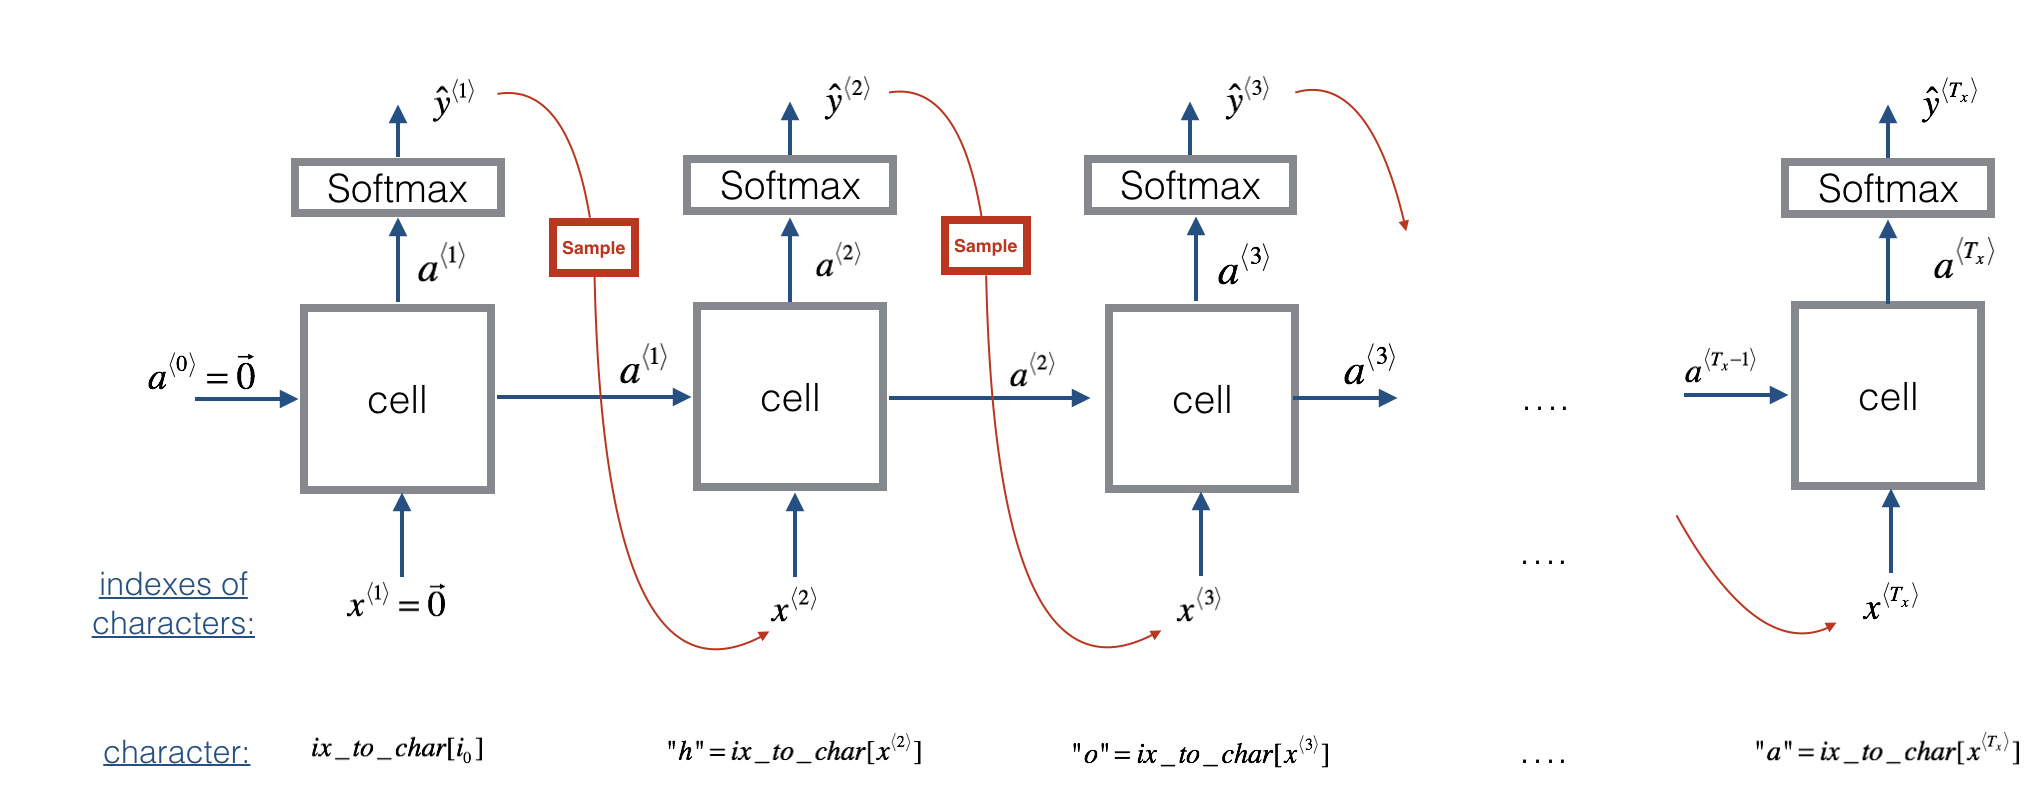

<a name='ex-2'></a>
### Exercise 2 - sample

To implement the `sample` function to sample characters, I followed 4 main steps:

- **Step 1**: Input the "dummy" vector of zeros $x^{\langle 1 \rangle} = \vec{0}$.
    - This is the default input before we've generated any characters.
    I also set $a^{\langle 0 \rangle} = \vec{0}$

- **Step 2**: Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$. Here were the equations used:

*hidden state:*  
$$ a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t+1 \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$

*activation:*
$$ z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$

*prediction:*
$$ \hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$

- Details about $\hat{y}^{\langle t+1 \rangle }$:
   - Note that $\hat{y}^{\langle t+1 \rangle }$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1).
   - $\hat{y}^{\langle t+1 \rangle}_i$ represents the probability that the character indexed by "i" is the next character.  

In [ ]:
print("Multiply 2D and 1D arrays: result is a 1D array\n",
      np.dot(matrix1,vector1D))
print("Multiply 2D and 2D arrays: result is a 2D array\n",
      np.dot(matrix1,vector2D))

Multiply 2D and 1D arrays: result is a 1D array
 [2 4 6]
Multiply 2D and 2D arrays: result is a 2D array
 [[2]
 [4]
 [6]]


In [ ]:
print("Adding a (3,) vector to a (3 x 1) vector\n",
      "broadcasts the 1D array across the second dimension\n",
      "Not what we want here!\n",
      np.dot(matrix1,vector1D) + matrix2
     )

Adding a (3,) vector to a (3 x 1) vector
 broadcasts the 1D array across the second dimension
 Not what we want here!
 [[2 4 6]
 [2 4 6]
 [2 4 6]]


- **Step 3**: Sampling:
    - Now that I have $y^{\langle t+1 \rangle}$, I wanted to select the next letter in the dinosaur name. If we select the most probable, the model will always generate the same result given a starting letter. To make the results more interesting, I used `np.random.choice` to select a next letter that is *likely*, but not always the same.
    - Pick the next character's **index** according to the probability distribution specified by $\hat{y}^{\langle t+1 \rangle }$.
    - This means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$, we will pick the index "i" with 16% probability.
    

- **Step 4**: Update to $x^{\langle t \rangle }$
    - The last step to implement in `sample()` is to update the variable `x`, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$.
    - I will represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character that I have chosen as the prediction.
    - I will then forward propagate $x^{\langle t + 1 \rangle }$ in Step 1 and keep repeating the process until I get a `"\n"` character, indicating that I have reached the end of the dinosaur name.

In [ ]:
def sample(parameters, char_to_ix, seed):
    """
    Sample a sequence of characters according to a sequence of probability distributions output of the RNN

    Arguments:
    parameters -- Python dictionary containing the parameters Waa, Wax, Wya, by, and b.
    char_to_ix -- Python dictionary mapping each character to an index.

    Returns:
    indices -- A list of length n containing the indices of the sampled characters.
    """

    # Retrieve parameters and relevant shapes from "parameters" dictionary
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]

    # Step 1: Create the a zero vector x that can be used as the one-hot vector
    # Representing the first character (initializing the sequence generation).
    x = np.zeros((vocab_size, 1))
    # Step 1': Initialize a_prev as zeros
    a_prev = np.zeros((n_a, 1))

    # Create an empty list of indices. This is the list which will contain the list of indices of the characters to generate
    indices = []

    # idx is the index of the one-hot vector x that is set to 1
    # All other positions in x are zero.
    # Initialize idx to -1
    idx = -1

    # Loop over time-steps t. At each time-step:
    # Sample a character from a probability distribution
    # And append its index (`idx`) to the list "indices".
    # We'll stop if we reach 50 characters
    # (which should be very unlikely with a well-trained model).
    # Setting the maximum number of characters helps with debugging and prevents infinite loops.
    counter = 0
    newline_character = char_to_ix['\n']

    while (idx != newline_character and counter != 50):

        # Step 2: Forward propagate x using the equations (1), (2) and (3)
        a = np.tanh(np.dot(Wax, x)+np.dot(Waa, a_prev) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)

        np.random.seed(counter + seed)

        # Step 3: Sample the index of a character within the vocabulary from the probability distribution y
        # (see additional hints above)
        idx = np.random.choice(list(range(vocab_size)), p = y.ravel())

        # Append the index to "indices"
        indices.append(idx)

        # Step 4: Overwrite the input x with one that corresponds to the sampled index `idx`.
        # (see additional hints above)
        x = np.zeros((vocab_size, 1))
        x[idx] = 1

        # Update "a_prev" to be "a"
        a_prev = a

        seed += 1
        counter +=1

    if (counter == 50):
        indices.append(char_to_ix['\n'])

    return indices

<a name='3'></a>
## 3 - Building the Language Model

<a name='3-1'></a>
### 3.1 - Gradient Descent

In this section I implemented a function performing one step of stochastic gradient descent (with clipped gradients). I went through the training examples one at a time, so the optimization algorithm will be stochastic gradient descent.

As a reminder, here are the steps of a common optimization loop for an RNN:


In [ ]:
def optimize(X, Y, a_prev, parameters, learning_rate = 0.01):
    """

    Arguments:
    X -- list of integers, where each integer is a number that maps to a character in the vocabulary.
    Y -- list of integers, exactly the same as X but shifted one index to the left.
    a_prev -- previous hidden state.
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        b --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    learning_rate -- learning rate for the model.

    Returns:
    loss -- value of the loss function (cross-entropy)
    gradients -- python dictionary containing:
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dWya -- Gradients of hidden-to-output weights, of shape (n_y, n_a)
                        db -- Gradients of bias vector, of shape (n_a, 1)
                        dby -- Gradients of output bias vector, of shape (n_y, 1)
    a[len(X)-1] -- the last hidden state, of shape (n_a, 1)
    """

    # Forward propagate through time
    loss, cache = rnn_forward(X, Y, a_prev, parameters)

    # Backpropagate through time
    gradients, a = rnn_backward(X, Y, parameters, cache)

    # Clip gradients between -5 (min) and 5 (max)
    gradients = clip(gradients,5)

    # Update parameters
    parameters = update_parameters(parameters, gradients, learning_rate)

    return loss, gradients, a[len(X)-1]

<a name='3-2'></a>
### 3.2 - Training the Model

In [ ]:
def model(data_x, ix_to_char, char_to_ix, num_iterations = 35000, n_a = 50, dino_names = 7, vocab_size = 27, verbose = False):
    """
    Trains the model and generates dinosaur names.

    Arguments:
    data_x -- text corpus, divided in words
    ix_to_char -- dictionary that maps the index to a character
    char_to_ix -- dictionary that maps a character to an index
    num_iterations -- number of iterations to train the model for
    n_a -- number of units of the RNN cell
    dino_names -- number of dinosaur names we want to sample at each iteration.
    vocab_size -- number of unique characters found in the text (size of the vocabulary)

    Returns:
    parameters -- learned parameters
    """

    # Retrieve n_x and n_y from vocab_size
    n_x, n_y = vocab_size, vocab_size

    # Initialize parameters
    parameters = initialize_parameters(n_a, n_x, n_y)

    # Initialize loss
    loss = get_initial_loss(vocab_size, dino_names)

    # Build list of all dinosaur names (training examples).
    examples = [x.strip() for x in data_x]

    # Shuffle list of all dinosaur names
    np.random.seed(0)
    np.random.shuffle(examples)

    # Initialize the hidden state of your LSTM
    a_prev = np.zeros((n_a, 1))

    last_dino_name = "abc"

    # Optimization loop
    for j in range(num_iterations):

        idx = j % len(examples)

        X = [None] + [char_to_ix[ch] for ch in examples[idx]]

        Y = X[1:] + [char_to_ix["\n"]]
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters)

        # debug statements to aid in correctly forming X, Y
        if verbose and j in [0, len(examples) -1, len(examples)]:
            print("j = " , j, "idx = ", idx,)
#         if verbose and j in [0]:
#             print("single_example =", single_example)
#             print("single_example_chars", single_example_chars)
#             print("single_example_ix", single_example_ix)
#             print(" X = ", X, "\n", "Y =       ", Y, "\n")

        # Use a latency trick to keep the loss smooth. It happens here to accelerate the training.
        loss = smooth(loss, curr_loss)

        # Every 2000 Iteration, generate "n" characters thanks to sample() to check if the model is learning properly
        if j % 2000 == 0:

            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')

            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):

                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                last_dino_name = get_sample(sampled_indices, ix_to_char)
                print(last_dino_name.replace('\n', ''))

                seed += 1

            print('\n')

    return parameters, last_dino_name

<a name='4'></a>
## 4 - Writing like Shakespeare

A similar task to character-level text generation (but more complicated) is generating Shakespearean poems. Instead of learning from a dataset of dinosaur names, we can use a collection of Shakespearean poems. Using LSTM cells, we can learn longer-term dependencies that span many characters in the text--e.g., where a character appearing somewhere a sequence can influence what should be a different character, much later in the sequence. These long-term dependencies were less important with dinosaur names, since the names were quite short.



In [ ]:
from __future__ import print_function
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from shakespeare_utils import *
import sys
import io

Loading text data...
Creating training set...
number of training examples: 31412
Vectorizing training set...
Loading model...


In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y, batch_size=128, epochs=1, callbacks=[print_callback])

246/246 [==============================] - 100s 408ms/step - loss: 2.5505


In [ ]:
generate_output()

Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: summmer day


Here is your poem: 

summmer days.
the prais' my hall busing thy eemend ve lend,
afre manners chick thy yel lilest selw frow hote,
 when sich thes dotfor thal simert arak
thou so dorse thy of the pured sicanness dayse,
tratantion be mage thy sill i know fille.
 

entwere's shu bnal i magiat on noth demow haurs,
and my i pely prois offored my she i ferse.
 o thy folso vire not my deloming,
the both thy nepure demend more strence 

<a name='5'></a>
## 5 - References
- This project took inspiration from Andrej Karpathy's implementation: https://gist.github.com/karpathy/d4dee566867f8291f086